# Refactor

Start with notebook 306 and refactor the code.  
Code improvement had been deferred during SOARS project.  

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-17 06:09:48 EDT


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-17 06:09:49.338275: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel-304"  
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load

In [4]:
PC_TRAINS=1000
NC_TRAINS=1000
PC_TESTS=40000
NC_TESTS=40000   
PC_LENS=(200,4000)
NC_LENS=(200,4000)   # Wen used 3500 for hyperparameter, 3000 for train
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   
show_time()

2021-08-17 06:09:50 EDT


In [5]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(True)  # ORF-restricted
loader.set_check_size(*PC_LENS)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
loader.set_check_size(*NC_LENS)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 55381
NC seqs loaded: 46919
2021-08-17 06:09:52 EDT


In [6]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(pcdf)
    #dataframe_length_filter(pcdf,PC_LENS))  # length-restricted
nc_all = dataframe_extract_sequence(ncdf)
    #dataframe_length_filter(ncdf,NC_LENS))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

#PC seqs pass filter: 55381
#NC seqs pass filter: 46919

2021-08-17 06:09:52 EDT
PC seqs pass filter: 55381
NC seqs pass filter: 46919


In [7]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequence characteristics:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1935.5395713331286
Average ORF length: 1047.2401906791138
NC seqs
Average RNA length: 1179.5947483961722
Average ORF length: 203.12651591039878
2021-08-17 06:10:06 EDT


## Data Prep

In [8]:
def combine_pos_and_neg(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    return X,y
Xseq,y=combine_pos_and_neg(pc_all,nc_all)
print("The first few shuffled labels:")
print(y[:30])
pc_all=None
nc_all=None
show_time()

The first few shuffled labels:
[0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0]
2021-08-17 06:10:08 EDT


In [9]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    for seq in seqs:
        # Critical to make new dict for each seq.
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
show_time()

2021-08-17 06:10:38 EDT


In [10]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 2000 = 2000
Reserved test set size= 100300 = 100300
2021-08-17 06:10:38 EDT


## Load a trained neural network

In [11]:
show_time()
model = load_model(BESTMODELPATH)
print(model.summary())

2021-08-17 06:10:38 EDT


2021-08-17 06:10:38.544611: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 06:10:38.617895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 06:10:38.619760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-17 06:10:38.619827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 06:10:38.632195: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 06:10:38.632257: I tensorflow/stream_executor

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                2720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

## Test the neural network

In [12]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on test data.
2021-08-17 06:10:39 EDT


2021-08-17 06:10:39.524504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 06:10:39.544593: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-17 06:10:41.840821: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 06:10:42.409540: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


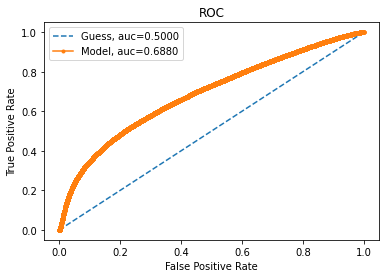

AUC: 68.80%
accuracy: 63.37%
2021-08-17 06:10:46 EDT


In [13]:
print("Accuracy on test data.")
show_time()
show_test_AUC(model,X_test,y_test)
show_test_accuracy(model,X_test,y_test)
show_time()